# 1.Data Collection

In [1]:
# Collect relevant tweets through the Twitter API.
import json
import requests
import tweepy as tw

In [2]:
# IMPORTANT: enter proper access credential in config_twitter_v2api.py file
import config_twitter_v2api as config_twitter

In [3]:
# Establish the Twitter v2 API connection, respecting the rate limit
api = tw.Client(bearer_token=config_twitter.bearer_token, wait_on_rate_limit=True)
api


In [4]:
# construct a search query
query = 'sneaker OR "sneakers" -is:retweet lang:en'

In [5]:
# decide how many tweets to query
###TODO increase this value later to collect a good dataset (try 10000 for instance)
ntweets = 10000
#ntweets = 10000

In [6]:
# collect recent tweets and convert to json
fields_sel = ['id', 'created_at', 'text', 'author_id', 'public_metrics']
tweets_resp = tw.Paginator(api.search_recent_tweets, query=query, tweet_fields=fields_sel,
                           max_results=100).flatten(limit=ntweets)
tweets = [t.data for t in tweets_resp]
len(tweets)

10000

In [7]:
# example tweet content (json structure)
tweets[0]

{'public_metrics': {'retweet_count': 4,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0},
 'created_at': '2022-08-01T02:14:41.000Z',
 'id': '1553927164835368970',
 'text': 'RT @megalosknow: AAAA HYUNJIN RYUJIN!!\nBISA KALI BISA ABIS ISAC SNEAKER CHALLENGE BERDUAAAAAAA!!!!\nhttps://t.co/kpKFvFadRU',
 'author_id': '1477483971168591875'}

In [8]:
# save tweets data to json file
file_out = f"raw_tweet_data_{ntweets}.json"
with open(file_out, mode='w') as f:
    f.write(json.dumps(tweets, indent=2))

# 2. Data Analysis

In [9]:
# Twitter data analysis task starter.
import html
import json
import string
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
# First collect the data in json-file; specify file name here (adjust the number as queried)
##fjson = 'raw_tweet_data_200.json'
fjson = 'raw_tweet_data_10000.json'

In [11]:
# read json file with tweets data
# https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files
with open(fjson) as file:
    data = json.load(file)
len(data)

10000

In [12]:
# tweet data record example: as documented for the Twitter API
# https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet
data[0]

{'public_metrics': {'retweet_count': 4,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0},
 'created_at': '2022-08-01T02:14:41.000Z',
 'id': '1553927164835368970',
 'text': 'RT @megalosknow: AAAA HYUNJIN RYUJIN!!\nBISA KALI BISA ABIS ISAC SNEAKER CHALLENGE BERDUAAAAAAA!!!!\nhttps://t.co/kpKFvFadRU',
 'author_id': '1477483971168591875'}

In [13]:
# create pandas dataframe from tweet text content
# https://stackoverflow.com/a/43175477
df_tweets = pd.DataFrame([t['text'] for t in data], columns=['text'])
df_tweets

,text
0,RT @megalosknow: AAAA HYUNJIN RYUJIN!!\nBISA K...
1,Livision Elena Sneakers\n⭐ 4.8\nLink : https:/...
2,sneakers bareng yok https://t.co/kr9HKuqlIf
3,yeji and hyunjin sneakers challenge cutie
4,Earn in Cryptocurrency/NFTs while working out ...
...,...
9995,RT @ChrisJo22923551: Just having a cup of coff...
9996,RT @SoumisArdent: Let’s thank them to use us b...
9997,Link: https://t.co/rKvN43FJMT
9998,Link: https://t.co/KWKhmKfnKq


In [14]:
# add selected columns from tweet data fields
df_tweets['retweets'] = [t['public_metrics']['retweet_count'] for t in data]
df_tweets['favorites'] = [t['public_metrics']['like_count'] for t in data]
df_tweets['user'] = [t['author_id'] for t in data]
df_tweets['replies']= [t['public_metrics']['reply_count'] for t in data]
df_tweets

,text,retweets,favorites,user,replies
0,RT @megalosknow: AAAA HYUNJIN RYUJIN!!\nBISA K...,4,0,1477483971168591875,0
1,Livision Elena Sneakers\n⭐ 4.8\nLink : https:/...,0,0,1464794845155934217,0
2,sneakers bareng yok https://t.co/kr9HKuqlIf,0,0,1498279128499298306,0
3,yeji and hyunjin sneakers challenge cutie,0,0,1364762534100692992,0
4,Earn in Cryptocurrency/NFTs while working out ...,0,0,1494708727370313729,0
...,...,...,...,...,...
9995,RT @ChrisJo22923551: Just having a cup of coff...,2,0,1384089348954415106,0
9996,RT @SoumisArdent: Let’s thank them to use us b...,74,0,1159862509362434048,0
9997,Link: https://t.co/rKvN43FJMT,0,0,1277530160758226945,0
9998,Link: https://t.co/KWKhmKfnKq,0,0,1277530160758226945,0


# 2.1 Data Cleaning 

In [15]:
# text cleaning function: see prior class modules
stop_words = set(stopwords.words('english'))

# strictly speaking, this is a closure: uses a wider-scope variable stop_words
# (disregard this note if you are a Python beginner)
def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

In [16]:
# add clean text column
# NOTE: apply in pandas applies a function to each element of the selected column
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
df_tweets['text_clean'] = df_tweets['text'].apply(text_cleanup)
df_tweets

,text,retweets,favorites,user,replies,text_clean
0,RT @megalosknow: AAAA HYUNJIN RYUJIN!!\nBISA K...,4,0,1477483971168591875,0,rt megalosknow aaaa hyunjin ryujin bisa kali b...
1,Livision Elena Sneakers\n⭐ 4.8\nLink : https:/...,0,0,1464794845155934217,0,livision elena sneakers link
2,sneakers bareng yok https://t.co/kr9HKuqlIf,0,0,1498279128499298306,0,sneakers bareng yok
3,yeji and hyunjin sneakers challenge cutie,0,0,1364762534100692992,0,yeji hyunjin sneakers challenge cutie
4,Earn in Cryptocurrency/NFTs while working out ...,0,0,1494708727370313729,0,earn working fitmint app fitmint sneakers nft ...
...,...,...,...,...,...,...
9995,RT @ChrisJo22923551: Just having a cup of coff...,2,0,1384089348954415106,0,rt chrisjo22923551 cup coffee favorite coffee ...
9996,RT @SoumisArdent: Let’s thank them to use us b...,74,0,1159862509362434048,0,rt soumisardent lets thank use us paying frida...
9997,Link: https://t.co/rKvN43FJMT,0,0,1277530160758226945,0,link
9998,Link: https://t.co/KWKhmKfnKq,0,0,1277530160758226945,0,link


# 2.2 Sentiment Analysis 

In [17]:
# sentiment analysis                                                                
def sentim_polarity(s):
    return TextBlob(s).sentiment.polarity

def sentim_subject(s):
    return TextBlob(s).sentiment.subjectivity

df_tweets['polarity'] = df_tweets['text_clean'].apply(sentim_polarity)
df_tweets['subjectivity'] = df_tweets['text_clean'].apply(sentim_subject)
df_tweets

,text,retweets,favorites,user,replies,text_clean,polarity,subjectivity
0,RT @megalosknow: AAAA HYUNJIN RYUJIN!!\nBISA K...,4,0,1477483971168591875,0,rt megalosknow aaaa hyunjin ryujin bisa kali b...,0.000000,0.000000
1,Livision Elena Sneakers\n⭐ 4.8\nLink : https:/...,0,0,1464794845155934217,0,livision elena sneakers link,0.000000,0.000000
2,sneakers bareng yok https://t.co/kr9HKuqlIf,0,0,1498279128499298306,0,sneakers bareng yok,0.000000,0.000000
3,yeji and hyunjin sneakers challenge cutie,0,0,1364762534100692992,0,yeji hyunjin sneakers challenge cutie,0.000000,0.000000
4,Earn in Cryptocurrency/NFTs while working out ...,0,0,1494708727370313729,0,earn working fitmint app fitmint sneakers nft ...,0.000000,0.500000
...,...,...,...,...,...,...,...,...
9995,RT @ChrisJo22923551: Just having a cup of coff...,2,0,1384089348954415106,0,rt chrisjo22923551 cup coffee favorite coffee ...,0.500000,1.000000
9996,RT @SoumisArdent: Let’s thank them to use us b...,74,0,1159862509362434048,0,rt soumisardent lets thank use us paying frida...,0.000000,0.000000
9997,Link: https://t.co/rKvN43FJMT,0,0,1277530160758226945,0,link,0.000000,0.000000
9998,Link: https://t.co/KWKhmKfnKq,0,0,1277530160758226945,0,link,0.000000,0.000000


# 2.3 Competitors Analysis 

In [18]:
# define the list of brands to analyze, consistent with the search topic
#  for which the tweets were collected
brands = ['lululemon','nike','adidas', 'asics']

In [19]:
# start a brand comparison dataframe
df_brands = pd.DataFrame(brands, columns=['brand'])
df_brands

,brand
0,lululemon
1,nike
2,adidas
3,asics


# 2.3.1 Competitors Analysis - nike 

In [20]:
# example: tweet subset mentioning a given brand
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html
df_tweets[df_tweets['text_clean'].str.contains("nike")]

,text,retweets,favorites,user,replies,text_clean,polarity,subjectivity
7,Kronikel Project Zoey Sneakers\n⭐ 4.9\nLink : ...,0,0,1464794845155934217,1,kronikel project zoey sneakers link,0.000000,0.000000
99,The Nike dunk black and white have to be the s...,0,2,30815198,0,nike dunk black white sneaker year day go outs...,-0.055556,0.161111
131,Nike baby-boys Sneaker Review https://t.co/Q8y...,0,0,604511949,0,nike sneakerreview,0.000000,0.000000
217,wrong! All the shoes in my shoe store are genu...,0,1,1543851254182338561,0,wrong shoes shoe store genuine nike airjordan ...,-0.050000,0.700000
225,🎉🎉🎉Snkrsfan New Releases\n🌼Nike Air Force 1 Lo...,0,1,1539091376390152192,1,snkrsfan new releases nike air force 1 olive c...,0.108182,0.437273
...,...,...,...,...,...,...,...,...
9868,RT @sneaker_george: 👟Travis Scott × Nike Air M...,366,0,1294328356976996354,0,rt travis scott nike air max 1 1 1 2rt 3dm,0.000000,0.000000
9882,RT @sneaker_george: 👟Travis Scott × Nike Air M...,366,0,844676029612355584,0,rt travis scott nike air max 1 1 1 2rt 3dm,0.000000,0.000000
9902,Nike Women&amp;#8217;s Flex Trainer 9 Sneaker\...,0,0,1277530160758226945,0,nike women 8217 flex trainer 9 sneaker price link,0.000000,0.000000
9918,RT @_at_mark00: 👟new sneaker👟\n\n1017 ALYX 9SM...,1,0,1709307326,0,rt new sneaker 1017 alyx 9sm nike air force 1 ...,0.136364,0.454545


# 2.3.2.Competitors Analysis - asics

In [21]:
# example: tweet subset mentioning a given brand
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html
df_tweets[df_tweets['text_clean'].str.contains("asics")]

,text,retweets,favorites,user,replies,text_clean,polarity,subjectivity
2633,Sneaker #Politics x Asics Gel-Lyte III OG Alwa...,0,0,1009517269658030082,0,sneaker politics x asics iii og always ready m...,0.200000,0.500000
3104,@tryagaintony @Sadamal29 New Balance is puttin...,0,2,4721922210,1,tryagaintony sadamal29 new balance putting gre...,0.367677,0.457071
3341,Check out this listing I just added to my #Pos...,0,0,2181037226,0,check listing added poshmark closet nib sale n...,0.000000,0.000000
3345,Check out this listing I just added to my #Pos...,0,0,2181037226,0,check listing added poshmark closet nib asics ...,0.000000,0.000000
3346,Check out this listing I just added to my #Pos...,0,0,2181037226,0,check listing added poshmark closet sold nib a...,0.000000,0.000000
4530,Asics Gel-Kayano 29 Running Shoe\n@ASICSameric...,0,0,1476122754948771841,0,asics 29 running shoe asicsamerica fmen asics ...,0.400000,0.400000
4832,ASICS 1191A148-020 Gel-Kayano 5 Og Mens Snea...,0,0,1045593347627180033,0,asics 5 og mens sneakers shoes casual blue gre...,-0.183333,0.355556
5563,This one’s for the nature lovers. Designed by ...,0,2,52514786,0,ones nature lovers designed asics developers k...,0.000000,0.000000
5578,"📉 MINIMO STORICO 📉\n\n📍 ASICS Gel-Sonoma 6, Sn...",0,0,1365969690238062595,0,minimo storico asics 6 sneaker donna silver eu...,0.000000,0.000000
7066,$52.95 -- ASICS Unisex GEL-PTG Shoes | Orig. $...,0,0,1283013007304466433,0,asics unisex shoes orig 130 smartcooldeals kic...,0.000000,0.000000


# 2.3.3.Competitors Analysis - adidas

In [22]:
# example: tweet subset mentioning a given brand
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html
df_tweets[df_tweets['text_clean'].str.contains("adidas")]

,text,retweets,favorites,user,replies,text_clean,polarity,subjectivity
167,Aug 2 New Release🐿️\nadidas Yeezy 450 Utility ...,0,0,1544214413477310466,0,aug 2 new release adidas yeezy 450 utility bla...,0.108947,0.486436
394,Adidas Original NMD R1 Women s #ad #sneakerhe...,0,0,1490511148675969027,0,adidas original nmd r1 women ad sneakerhead,0.375000,0.750000
451,Check out this listing I just added to my #Pos...,0,0,492665292,0,check listing added poshmark closet guc adidas...,0.000000,0.000000
596,🎉🎉🎉New Releases (August 1/2)\n🌼Nike Air Force ...,0,1,1539091376390152192,0,new releases august nike air force 1 mid pine ...,-0.090043,0.283983
597,Check out this listing I just added to my #Pos...,0,0,1248368440991195136,0,check listing added poshmark closet adidas wom...,0.000000,0.000000
...,...,...,...,...,...,...,...,...
9552,#إقالة_وزير_التعليم_مطلب\nadidas DURAMO 10 men...,1,0,2438992039,0,adidas duramo 10 mens sneaker,0.000000,0.000000
9768,Ad: The adidas Ultra 4D ‘Almost Lime’ just red...,1,5,1400833752,0,ad adidas ultra 4d almost lime reduced 179 99,0.000000,0.000000
9801,adidas Women’s Advantage Sneaker https://t.co/...,0,0,1072689975999782913,0,adidas womens advantagesneaker,0.000000,0.000000
9863,*_NEW ✅ 2022 ADIDAS TRIP_COSSY BIG SOLE Sneake...,0,1,1268702212445872128,0,2022 adidas big sole sneakers big drip newest ...,0.000000,0.150000


# 2.4 Brand Sentiment Analysis

In [23]:
# function to compute average sentiment of tweets mentioning a given brand
def brand_sentiment(b):
    return df_tweets[df_tweets['text_clean'].str.contains(b)]['polarity'].mean()

In [24]:
# brand sentiment comparison
df_brands['average_sentiment'] = df_brands['brand'].apply(brand_sentiment)
df_brands

,brand,average_sentiment
0,lululemon,-0.131250
1,nike,0.089320
2,adidas,0.116189
3,asics,0.065362


# 2.5 Content Sentiment Analysis 

In [25]:
# highest sentiment tweets                                                              
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
df_tweets.sort_values(by='polarity', ascending=False).head(20)

,text,retweets,favorites,user,replies,text_clean,polarity,subjectivity
3098,@TFGmykL @ChainTechLabs @TFGwhitelist @sneaker...,1,2,1487176422783426562,0,tfgmykl chaintechlabs tfgwhitelist sneakerhead...,1.0,0.3
2145,What's the best trainers/sneakers to cum in or...,0,2,1375853013571620867,2,best cum cum,1.0,0.3
6970,The Best Sneaker Shops in Toronto https://t.co...,0,0,1506010418724155394,0,best sneaker shops toronto,1.0,0.3
4689,RIP to one of the greatest to ever lace up a p...,0,1,235342171,0,rip one greatest ever lace pair sneakers ripbi...,1.0,1.0
1930,RT @MutamiSusan_: One of the best sneaker hust...,14,0,1518867425516740608,0,rt one best sneaker hustlers zimbabwe,1.0,0.3
7689,End of sneakers 👟 promotion 🎉🌟 Well done girls...,0,0,1336498687648833537,0,end sneakers promotion well done girls itzyoff...,1.0,1.0
2881,RT @MutamiSusan_: One of the best sneaker hust...,14,0,1400440637611286530,0,rt one best sneaker hustlers zimbabwe,1.0,0.3
2880,RT @MutamiSusan_: One of the best sneaker hust...,14,0,1406338694454333440,0,rt one best sneaker hustlers zimbabwe,1.0,0.3
2879,RT @MutamiSusan_: One of the best sneaker hust...,14,0,1191291673315356673,0,rt one best sneaker hustlers zimbabwe,1.0,0.3
6092,@PrettyBeluce Put On Your Best Workout Sneaker...,0,1,863002101928132612,1,prettybeluce put best workout sneakers go lose...,1.0,0.3


In [26]:
# most retweeted content
df_tweets.sort_values(by='retweets', ascending=False).head(20)
# https://twitter.com/i/user/{usrid}                                                  

,text,retweets,favorites,user,replies,text_clean,polarity,subjectivity
2244,RT @Aliq87: Costco now has the best sneaker bo...,13870,0,1368970957734416386,0,rt aliq87 costco best sneaker box container ga...,0.185417,0.493750
2840,RT @Aliq87: Costco now has the best sneaker bo...,13870,0,1348480209171881984,0,rt aliq87 costco best sneaker box container ga...,0.185417,0.493750
1251,RT @stpr_apparel: 🍓STPR LOW CUT SNEAKER👟\nWHIT...,9415,0,1364176015954644994,0,rt stpr low cut sneaker white black pink 3 stp...,-0.066667,0.258333
1250,RT @stpr_apparel: 🍓STPR LOW CUT SNEAKER👟\nWHIT...,8688,0,1364176015954644994,0,rt stpr low cut sneaker white black pink 3 stp...,-0.066667,0.258333
8165,RT @STPR_records: 🍓ご好評につき！！✨✨\n\n🍓5/9(月)20:00か...,6894,0,1511241871817056261,0,rt stpr low cut sneaker,0.000000,0.300000
6338,RT @Stepnofficial: Flex your BNBChain or Solan...,6762,0,951356486982291456,0,rt stepnofficial flex bnbchain solana sneaker ...,0.800000,0.400000
341,RT @Stepnofficial: Flex your BNBChain or Solan...,6762,0,1306810242311749632,0,rt stepnofficial flex bnbchain solana sneaker ...,0.800000,0.400000
1652,RT @Stepnofficial: Flex your BNBChain or Solan...,6762,0,1476050432355098627,0,rt stepnofficial flex bnbchain solana sneaker ...,0.800000,0.400000
6098,RT @Stepnofficial: Flex your BNBChain or Solan...,6762,0,291471089,0,rt stepnofficial flex bnbchain solana sneaker ...,0.800000,0.400000
1859,RT @Stepnofficial: Flex your BNBChain or Solan...,6762,0,4883662526,0,rt stepnofficial flex bnbchain solana sneaker ...,0.800000,0.400000


In [27]:
# top-20 users producing most retweeted content
df_tweets.sort_values(by='retweets', ascending=False).head(20)['user']

2244    1368970957734416386
2840    1348480209171881984
1251    1364176015954644994
1250    1364176015954644994
8165    1511241871817056261
6338     951356486982291456
341     1306810242311749632
1652    1476050432355098627
6098              291471089
1859             4883662526
5996    1495697281739374594
1310    1491634857021100034
8478    1545716704432513025
6155    1062578718214770688
8259    1380774695402831873
400     1524411723851071488
5622     747987364090286080
1316    1004246234809491456
601      997263217716948994
9468    1424463553533145089
Name: user, dtype: object

# 2.6 Keywords Analysis 

In [28]:
# combine all text for a specific brand
def brand_all_text(b):
    # https://stackoverflow.com/a/51871650
    return ' '.join(df_tweets[df_tweets['text_clean'].str.contains(b)]['text_clean'])

In [29]:
brand_all_text('lululemon')

'also horrible experiences blocked numerous accounts dead giveaways baby voice wear lululemon leggings sneakers tie claims give 1k shady deposit etc hey lululemon puerto rico considered international destination use usps believe considering pr intl destination letting get sneakers thanks help'

In [31]:
brand_all_text('nike')

'kronikel project zoey sneakers link nike dunk black white sneaker year day go outside see someone rocking even crazier type ppl see rocking range nike sneakerreview wrong shoes shoe store genuine nike airjordan sneakers shoes taiwan hobipalooza alchemyofsouls kevin snkrsfan new releases nike air force 1 olive canvas new balance 2002rgrey nike sb dunk lowgreen apple jordan 1 retro low ogmystic navy nike dunk highpink prime nike sb dunk high prokcdc nike newbalance jordan airforce dunk newreleases sneakers nike much cost buy one dem bots sneakers homie warmonitor3 want see dead man white 300 nike sneakers blue laces hey today everyone favorite harmful company nike average emits kilograms carbon dioxide per sneaker knew climate change real thing find else swept underneath rug rt sneakernews better sneaker heat la flames nike collaborations shop latest ebaysneakers new releases august nike air force 1 mid pine green adidas exhibit b grey team dark green w adidas yeezy foam rnr mx carbon a

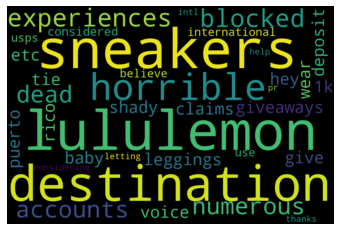

In [32]:
# most common twet content keywords for a specific brand
# https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
b = 'lululemon'
wc = WordCloud(width=1200, height=800, max_font_size=200, collocations=False).generate(brand_all_text(b))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

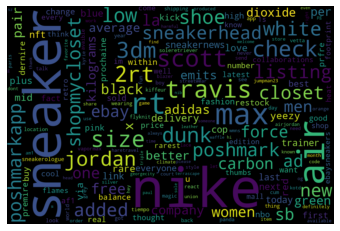

In [33]:
# most common twet content keywords for a specific brand
# https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
b = 'nike'
wc = WordCloud(width=1200, height=800, max_font_size=200, collocations=False).generate(brand_all_text(b))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

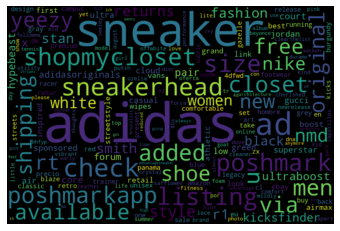

In [34]:
# most common twet content keywords for a specific brand
# https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
b = 'adidas'
wc = WordCloud(width=1200, height=800, max_font_size=200, collocations=False).generate(brand_all_text(b))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

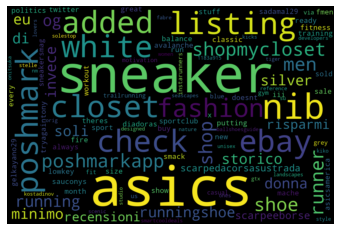

In [35]:
# most common twet content keywords for a specific brand
# https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
b = 'asics'
wc = WordCloud(width=1200, height=800, max_font_size=200, collocations=False).generate(brand_all_text(b))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()